In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import wget

In [2]:
# download data
if not os.path.exists('prediction-challenge-01-data.npz'):
    url = 'https://git.imp.fu-berlin.de/yuxuac94/'\
    'deep-learning-examples/-/raw/master/01-Basic/'\
    'prediction-challenge-01-data.npz'
    wget.download(url, './prediction-challenge-01-data.npz')

with np.load('prediction-challenge-01-data.npz') as fh:
    data_x = fh['data_x']
    data_y = fh['data_y']
    test_x = fh['test_x']

print(data_x.shape, data_x.dtype)
print(data_y.shape, data_y.dtype)
print(test_x.shape, test_x.dtype)

(20000, 1, 28, 28) float32
(20000,) int64
(2000, 1, 28, 28) float32


In [3]:
# split the data into train and valid set: 16000 vs. 4000
train_size = 18000
train_x, val_x = data_x[:train_size, ], data_x[train_size:, ]
train_y, val_y = data_y[:train_size, ], data_y[train_size:, ]

In [4]:
# hyper-parameters
hidden_size = 512
num_classes = 10
num_epochs = 50
batch_size = 512
learning_rate = 0.002
weight_decay = 0.01
dropout = 0

# set device
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

In [5]:
# create datasloader
train_loader = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_loader = train_loader.shuffle(
    buffer_size=train_x.shape[0], 
    reshuffle_each_iteration=True
).batch(batch_size)

In [6]:
# build the neural network of 2 fc-layers
class NeuralNet(keras.Model):
    def __init__(self, hidden_size, output_size, 
                 weight_decay=0, dropout=0):
        super(NeuralNet, self).__init__()
        self.regularizer = keras.regularizers.l2(weight_decay)

        self.flatten = layers.Flatten()
        self.fc1 = keras.Sequential([
            layers.Dense(units=hidden_size, 
                         activation=tf.nn.relu, 
                         kernel_regularizer=self.regularizer),
            layers.Dropout(rate=dropout)
        ])
        self.fc2 = layers.Dense(units=output_size, 
                                kernel_regularizer=self.regularizer)

    # forward pass
    def call(self, x):
        out = self.flatten(x)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

    # get L2-loss
    def l2_loss(self):
        total_layers_loss = self.fc1.losses + self.fc2.losses
        return tf.math.reduce_sum(total_layers_loss)

In [7]:
# set model and optimizer
model = NeuralNet(hidden_size=hidden_size, 
                  output_size=num_classes,
                  weight_decay=weight_decay, 
                  dropout=dropout)
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

In [8]:
# compute loss for a batch
def cross_entropy_loss(outputs, labels):
    labels = tf.cast(labels, tf.int64)
    # prediction loss
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=labels, logits=outputs)
    return tf.reduce_mean(loss)


def accuracy(outputs, labels):
    hit = tf.equal(tf.argmax(outputs, 1), 
                   tf.cast(labels, tf.int64))
    return tf.reduce_mean(tf.cast(hit, tf.float32), 
                          axis=-1)

In [9]:
# train the model
best_val_acc = 0
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.numpy(), labels.numpy()

        # wrap computation inside for automatic differentiation
        with tf.GradientTape() as g:
            # forward pass
            outputs = model(images, training=True)
            loss =  cross_entropy_loss(outputs, labels)
            # regularization loss
            loss += model.l2_loss()
            train_acc = accuracy(outputs, labels)
        
        # backward pass
        trainable_variables = model.trainable_variables
        grad = g.gradient(loss, trainable_variables)
        optimizer.apply_gradients(
            zip(grad, trainable_variables)
        )

    # report training loss and accuracy for the last batch 
    print('Epoch [{}/{}], Training Loss: {:.4f}'.format(
        epoch + 1, num_epochs, loss.numpy()))
    print('Training Accuracy: {:.3f}%'.format(100 * train_acc))

    # validate after each epoch
    images, labels = val_x, val_y
    outputs = model(images, training=False)
    val_acc = accuracy(outputs, labels)
    print('Validation Accuracy: {:.3f}%'.format(100 * val_acc))
    print('=' * 50)

    # save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        if best_val_acc > 0.95:
            model.save_weights('./saved_model.ckpt', overwrite=True)

print('Best Valid Accuracy: {:.3f}%'.format(100 * best_val_acc))

Epoch [1/50], Training Loss: 10.4875
Training Accuracy: 90.000%
Validation Accuracy: 88.950%
Epoch [2/50], Training Loss: 5.4624
Training Accuracy: 95.000%
Validation Accuracy: 92.200%
Epoch [3/50], Training Loss: 5.1606
Training Accuracy: 92.500%
Validation Accuracy: 93.050%
Epoch [4/50], Training Loss: 4.6492
Training Accuracy: 97.500%
Validation Accuracy: 93.200%
Epoch [5/50], Training Loss: 4.0364
Training Accuracy: 96.250%
Validation Accuracy: 93.100%
Epoch [6/50], Training Loss: 3.4042
Training Accuracy: 98.750%
Validation Accuracy: 93.850%
Epoch [7/50], Training Loss: 3.2820
Training Accuracy: 96.250%
Validation Accuracy: 94.550%
Epoch [8/50], Training Loss: 2.9833
Training Accuracy: 100.000%
Validation Accuracy: 94.750%
Epoch [9/50], Training Loss: 2.8384
Training Accuracy: 100.000%
Validation Accuracy: 94.550%
Epoch [10/50], Training Loss: 2.8417
Training Accuracy: 96.250%
Validation Accuracy: 94.400%
Epoch [11/50], Training Loss: 2.7195
Training Accuracy: 97.500%
Validation A

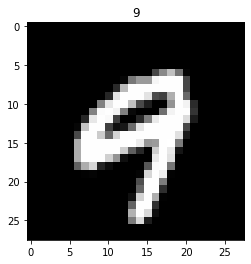

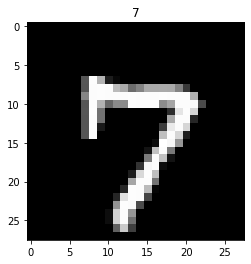

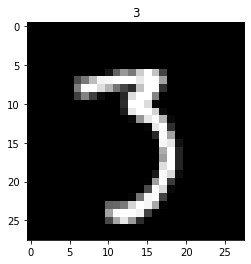

In [10]:
# load the saved model
saved_model = NeuralNet(hidden_size=hidden_size, 
                        output_size=num_classes)
saved_model.load_weights('./saved_model.ckpt')

# predict on test set with the saved model
with torch.no_grad():
    outputs = saved_model(test_x, training=False)
    test_pred = tf.argmax(outputs, 1).numpy()

# show some answers
for i in range(3):
    plt.imshow(test_x[i].reshape(28, 28), cmap='gray')
    plt.title(test_pred[i])
    plt.show()